# **Comparison Between Linear Regression and Quantile Regression for RecommendationCount and SteamSpyOwners**


# **Setup**

**Import packages and load file**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.stats.stattools
from mpl_toolkits import mplot3d

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

#New import
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group036_fa20/master/Datasets/games-features.csv?token=AFASGDC5O2ECVQU4DOAV5C272ZLT6')

# **Data Cleaning**

**Extract Relevant Columns**

**RecommendationCount** - (Int) Number of people who recommended the game

**SteamSpyOwners** - (Int) Number of people who own the game

**Drop games with 0 owners**

**SteamSpyOwnersLog** - (Float) Column that is the log transformation of the number of people who own the game

In [3]:
df = df[df['SteamSpyOwners'] > 0]

df['SteamSpyOwnersLog'] = np.log(df['SteamSpyOwners'])

**Drop games whose release dates cannot be identified**

**Since our dataset was updated in 2016, we decided to only include games released in 2016 or before 2016**

**We only found a single game on Steam that was not on Windows. This is an outlier, so we decided to drop it.**

In [4]:
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors = 'coerce')
df = df.loc[df['ReleaseDate'].notnull()]
df = df.loc[df['ReleaseDate'] < pd.datetime(2017, 1, 1)]


df = df[df['PlatformWindows'] == True]

# **Linear Regression Analysis**

**recommendation_log_df** - DataFrame which drops games with 0 recommendations and creates a column for log transformation of RecommendationCount

**RecommendationCountLog** - (Float) Natural log transformation of RecommendationCount

In [5]:
recommendation_log_df = df[df['RecommendationCount'] > 0]
recommendation_log_df['RecommendationCountLog'] = np.log(recommendation_log_df['RecommendationCount'])

**Check conditions for performing linear regression**

**Assumptions**

- We assume that our data is independent of one another, as the games created don't have a significant effect on other games. 
- There is no multicollinearity as we only have one predictor variable. 

**Condition 1**: Plot looks linear

After plotting out the two features, the plot looks pretty linear. 

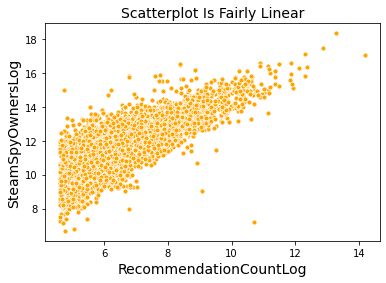

In [6]:
sns.scatterplot(x='RecommendationCountLog', y='SteamSpyOwnersLog', data=recommendation_log_df, s=25, color='orange')
plt.title('Scatterplot Is Fairly Linear', fontsize=14)
plt.xlabel('RecommendationCountLog', fontsize = 14)
plt.ylabel('SteamSpyOwnersLog', fontsize = 14)
plt.show()

**Condition 2**: Randomness in Residual Plot

Unfortunately, our data doesn't seem to have a random residual plot, so using a linear regression might not be the most accurate. 

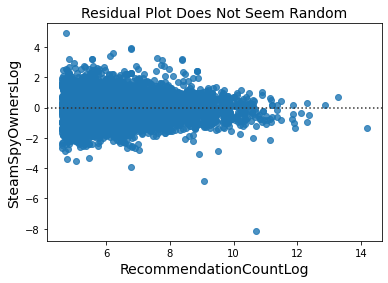

In [7]:
sns.residplot(data=recommendation_log_df, x='RecommendationCountLog', y='SteamSpyOwnersLog')
plt.title('Residual Plot Does Not Seem Random', fontsize = 14)
plt.xlabel('RecommendationCountLog', fontsize=14)
plt.ylabel('SteamSpyOwnersLog', fontsize=14)
plt.show()

**Condition 3**: Data is normally distributed

While SteamSpyOwnersLog seems to be roguhly normal, RecommendationCountLog is highly skewed right. So our data doesn't pass this condition as well.

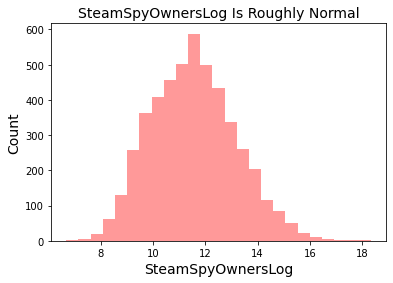

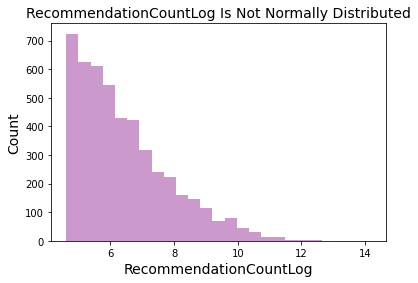

In [8]:
sns.distplot(recommendation_log_df['SteamSpyOwnersLog'], bins = 25, kde = False, color='red')
plt.title('SteamSpyOwnersLog Is Roughly Normal', fontsize = 14)
plt.xlabel('SteamSpyOwnersLog', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

sns.distplot(recommendation_log_df['RecommendationCountLog'], bins=25, kde=False, color='purple')
plt.title('RecommendationCountLog Is Not Normally Distributed', fontsize = 14)
plt.xlabel('RecommendationCountLog', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

**Performing Linear Regression**

Although our data doesn't pass all conditions, this just means that performing a linear regression might not be the most accurate regression. However, since we know that our data seems to have a linear relationship, we'll see if performing linear regression yields any promising results.

Our $R^2$ value is 0.615, which means that our linear regression line accounts for 61.5% of the variability we see in our data. 

R^2 score:  0.6198269861894454


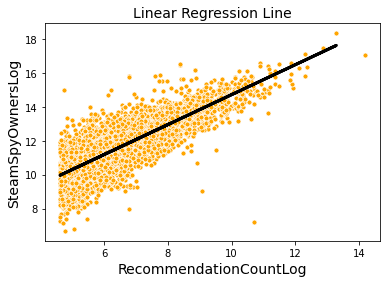

In [9]:
x_train, x_test, y_train, y_test = train_test_split(np.array(recommendation_log_df['RecommendationCountLog']), 
                                                    np.array(recommendation_log_df['SteamSpyOwnersLog']), test_size = 0.3)
reg = LinearRegression()
#Fit
reg.fit(np.reshape(x_train, (-1,1)), np.reshape(y_train, (-1, 1)))
predicted = reg.predict(np.reshape(x_test, (-1,1)))
#R^2
print('R^2 score: ', reg.score(np.reshape(x_train, (-1,1)), np.reshape(y_train, (-1, 1))))
#Plot regression line and scatter
import matplotlib.pyplot as plt
plt.plot(x_test, predicted, color = 'black', linewidth = 3)
sns.scatterplot(x='RecommendationCountLog', y='SteamSpyOwnersLog', data=recommendation_log_df, s=25, color='orange')
plt.title('Linear Regression Line', fontsize = 14)
plt.xlabel('RecommendationCountLog', fontsize = 14)
plt.ylabel('SteamSpyOwnersLog', fontsize = 14)
plt.show()

**Summary Statistics**

From our table, we can see that linear regression line calculated has an intercept of 5.8418 and a slope of 0.8884. 

**Linear Regression: y = 5.8418 + 0.8884x**

The p-value of the slope suggests that there is a relationship between RecommendationCountLog and SteamSpyOwnersLog. 

Our RMSE (Root Mean Squared Error) for our linear regression is also fairly small ranging from 0.01 to 0.04. 

In [10]:
outcome, predictors = patsy.dmatrices('SteamSpyOwnersLog ~ RecommendationCountLog', recommendation_log_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

# RMSE Calculation
print('RMSE:', np.sqrt(np.mean(y_test - predicted)**2))

                            OLS Regression Results                            
Dep. Variable:      SteamSpyOwnersLog   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     8275.
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:00:48   Log-Likelihood:                -6735.3
No. Observations:                4824   AIC:                         1.347e+04
Df Residuals:                    4822   BIC:                         1.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

# **Quantile Regression Analysis**

We take the quantile regression of our data because our data doesn't fit the conditions of a linear regression. Instead, by taking the quantile regression, we can gain an understanding of the changing variability we see in our plots. 

When we take a quantile regression, we plot out multiple linear regression lines based on the different quantile of our data (in our case 10 different quantiles). This gives allows us to make predictions with varying confidence levels. 

**Performing Quantile Regression**

**Summary Statistic of Least Absolute Deviation**

This following table contains the intercept and slope of the regression line for the median of our data, or quantile = 0.5. 

We found that the regression line follows the following equation: **SteamSpyOwnersLog = 5.8126 + 0.8956 * RecommendationCountLog**

In [11]:
mod = smf.quantreg('SteamSpyOwnersLog ~ RecommendationCountLog', recommendation_log_df)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:      SteamSpyOwnersLog   Pseudo R-squared:               0.3911
Model:                       QuantReg   Bandwidth:                      0.2984
Method:                 Least Squares   Sparsity:                        2.777
Date:                Thu, 10 Dec 2020   No. Observations:                 4824
Time:                        18:00:48   Df Residuals:                     4822
                                        Df Model:                            1
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.8126      0.091     63.645      0.000       5.634       5.992
RecommendationCountLog     0.8956      0.014     64.566      0.000       0.868       0.923


**Creating DataFrame of Intercepts and Coefficients**

Here we calculate the interecept and coefficients of each quantile we're interested in, which is from 0.05 to 0.95 and every 0.1 in between. 

**models** - DataFrame containing our relevant information for quantile regression

**quantile** - (float) Quantile corresponding to the equation

**intercept** - (float) Intercept of the regression line

**coef** - (float) Coefficient/Slope of regression line

In [12]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['RecommendationCountLog']] + \
            res.conf_int().loc['RecommendationCountLog'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['quantile', 'intercept', 'coef', 'lb', 'ub'])

ols = smf.ols('SteamSpyOwnersLog ~ RecommendationCountLog', recommendation_log_df).fit()
ols_ci = ols.conf_int().loc['RecommendationCountLog'].tolist()
ols = dict(intercept = ols.params['Intercept'],
           coef = ols.params['RecommendationCountLog'],
           lb = ols_ci[0],
           ub = ols_ci[1])

# a is the intercept and b is the coefficient

print(models)
print(ols)

   quantile  intercept      coef        lb        ub
0      0.05   3.598587  0.998912  0.959536  1.038288
1      0.15   4.306440  0.965609  0.937768  0.993451
2      0.25   4.744199  0.947448  0.920695  0.974201
3      0.35   5.198028  0.922859  0.895023  0.950695
4      0.45   5.606326  0.904873  0.877048  0.932698
5      0.55   6.089224  0.874216  0.848231  0.900202
6      0.65   6.511358  0.850178  0.826014  0.874341
7      0.75   6.934566  0.826662  0.803884  0.849441
8      0.85   7.508801  0.785179  0.762607  0.807751
9      0.95   8.192807  0.754887  0.724078  0.785697
{'intercept': 5.841788253468847, 'coef': 0.8884094801676276, 'lb': 0.8692628312146111, 'ub': 0.907556129120644}


**Plot out Quantile Regression**

We plot out the regression lines found in each quantile we want and the ordinary least squares regression line to see the relationship between RecommendationCoungLog and SteamSpyOwnersLog. 

We found that using quantile regression, we can now make predictions based on RecommendationCountLog to find SteamSpyOwnersLog, and that we can use a confidence interval as a prediction.  

The highlighted line in blue, or the Ordinary Least Squares Regression line is the 50th quantile regression line and considers the median of our data. 

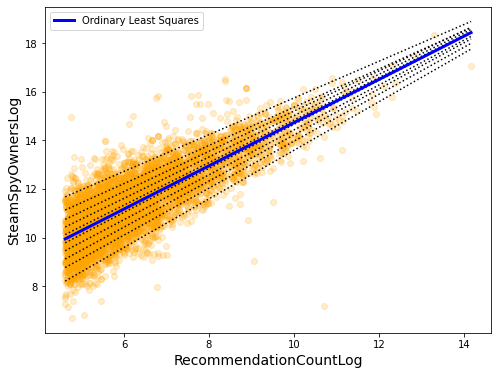

In [13]:
recommendation_log_min = recommendation_log_df.RecommendationCountLog.min()
recommendation_log_max = recommendation_log_df.RecommendationCountLog.max()
x = np.arange(recommendation_log_min, recommendation_log_max+0.1, (recommendation_log_max - recommendation_log_min) / 10)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.intercept[i], models.coef[i])
    ax.plot(x, y, linestyle='dotted', color='black')

y = get_y(ols['intercept'], ols['coef'])

ax.plot(x, y, color='blue', label='Ordinary Least Squares', linewidth = 3)
ax.scatter(recommendation_log_df.RecommendationCountLog, recommendation_log_df.SteamSpyOwnersLog, alpha=.2, color='orange')
legend = ax.legend()
ax.set_xlabel('RecommendationCountLog', fontsize=14)
ax.set_ylabel('SteamSpyOwnersLog', fontsize=14)
plt.show()

**Quantile Regression Equations for Each Quantile**

We can create regression equations for each quantile we calculated. Now that we have an equation for each quantile, we can create a confidence interval prediction. 

x = RecommendationCountLog

y = SteamSpyOwnersLog

**Median 50th Quantile**: y = 5.8126 + 0.8956x

5th Quantile: y = 3.5986 + 0.9989x

15th Quantile: y = 4.3064 + 0.9656x

25th Quantile: y = 4.7442 + 0.9474x

35th Quantile: y = 5.198 + 0.9229x

45th Quantile: y = 5.6063 + 0.9049x

55th Quantile: y = 6.0892 + 0.8742x

65th Quantile: y = 6.5114 + 0.8502x

75th Quantile: y = 6.9346 + 0.8267x

85th Quantile: y = 7.5088 + 0.7852x

95th Quantile: y = 8.1928 + 0.7549x

In [14]:
# models[q, a, b]
for i in range(models.shape[0]):
  row = models.iloc[i]
  print('{0}th Quantile: y = {1} + {2}x'.format(int(row['quantile'] * 100), row['intercept'].round(4), row['coef'].round(4)))

5th Quantile: y = 3.5986 + 0.9989x
15th Quantile: y = 4.3064 + 0.9656x
25th Quantile: y = 4.7442 + 0.9474x
35th Quantile: y = 5.198 + 0.9229x
45th Quantile: y = 5.6063 + 0.9049x
55th Quantile: y = 6.0892 + 0.8742x
65th Quantile: y = 6.5114 + 0.8502x
75th Quantile: y = 6.9346 + 0.8267x
85th Quantile: y = 7.5088 + 0.7852x
95th Quantile: y = 8.1928 + 0.7549x


When we compare our linear regression with our quantile regression, we can see that our Least Squares Regression is actually really similar to our Least Absolute Deviation Regression. The difference between the two is that Least Squares is built around the mean of the data while Least Absolute Deviation Regression is calculated around the median. 

However, quantile regression is better to use because of our non-constant variability in our data. Quantile regression allows us to take a confidence interval to predict the number of owners for a game given the recommendation count. 